In [ ]:
!git clone https://github.com/NivraLeak/datasetMask.git

Cloning into 'datasetMask'...
remote: Enumerating objects: 8851, done.
remote: Counting objects: 100% (8851/8851), done.
remote: Compressing objects: 100% (8845/8845), done.
remote: Total 8851 (delta 1), reused 8847 (delta 0), pack-reused 0
Receiving objects: 100% (8851/8851), 216.37 MiB | 29.96 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (8983/8983), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from keras.applications.mobilenet import MobileNet, preprocess_input 
from keras.losses import categorical_crossentropy

#  Construcción del modelo para entrenar la data

In [ ]:
# modelo mobilenet

base_model = MobileNet( input_shape=(224,224,3), include_top= False )

for layer in base_model.layers:
  layer.trainable = False


x = Flatten()(base_model.output)
x = Dense(units=3 , activation='softmax' )(x)

# crear modelo
model = Model(base_model.input, x)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy']  )

# Preparando la data

In [ ]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2, 
     shear_range = 0.2, 
     horizontal_flip=True, 
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/datasetMask/data/original", 
                                               target_size=(224,224), 
                                               batch_size=32,
                                  )


train_data.class_indices

Found 8982 images belonging to 3 classes.


{'incorrect': 0, 'withMask': 1, 'withoutMask': 2}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255 )

val_data = val_datagen.flow_from_directory(directory= "/content/datasetMask/data/original", 
                                           target_size=(224,224), 
                                           batch_size=32,
                                  )

Found 8982 images belonging to 3 classes.


# Visualización de la data del entrenamiento

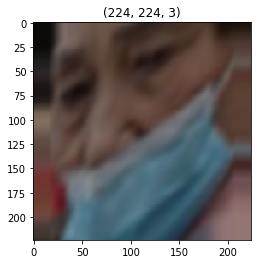

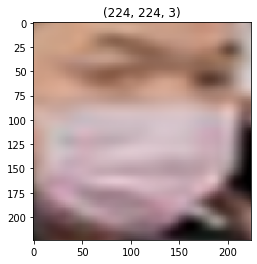

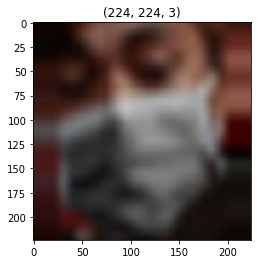

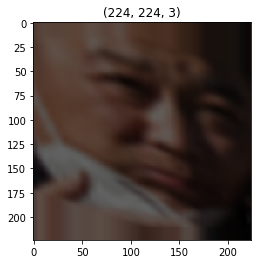

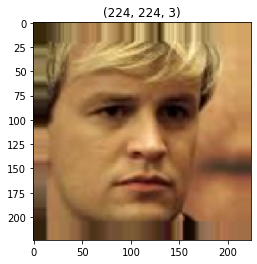

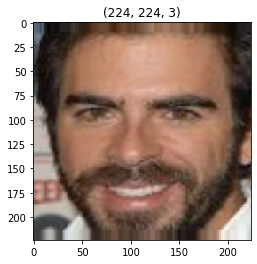

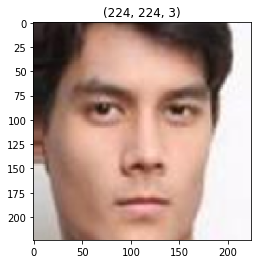

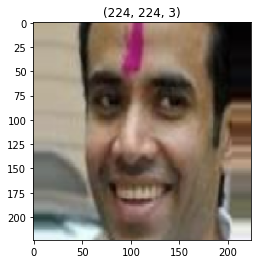

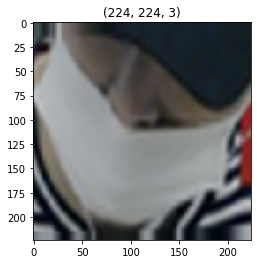

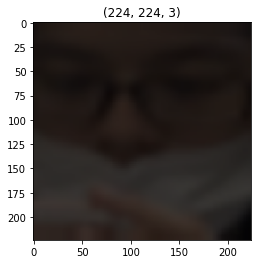

In [ ]:
# visualizar imagenes en el train data

t_img , label = train_data.next()

def plotImages(img_arr, label):
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

# llamar imagenes
plotImages(t_img, label)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# funcion del early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

# checkpoint del modelo
mc = ModelCheckpoint(filepath="best_model.h5", monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode = 'auto')

# agregar callback en lista
call_back = [es, mc]

In [ ]:
hist = model.fit(train_data, 
                           steps_per_epoch= 100, 
                           epochs= 30, 
                           validation_data= val_data, 
                           validation_steps= 8, 
                           callbacks=[es,mc])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.9275
Epoch 00001: val_accuracy improved from -inf to 0.97656, saving model to best_model.h5
100/100 [==============================] - 43s 429ms/step - loss: 1.0184 - accuracy: 0.9275 - val_loss: 0.1253 - val_accuracy: 0.9766
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9809
Epoch 00002: val_accuracy improved from 0.97656 to 0.98828, saving model to best_model.h5
100/100 [==============================] - 42s 420ms/step - loss: 0.1767 - accuracy: 0.9809 - val_loss: 0.0789 - val_accuracy: 0.9883
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9806
Epoch 00003: val_accuracy did not improve from 0.98828
100/100 [==============================] - 42s 418ms/step - loss: 0.1596 - accuracy: 0.9806 - val_loss: 0.2470 - val_accuracy: 0.9727
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.0952 -

In [ ]:
# Cargar modelo
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [ ]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

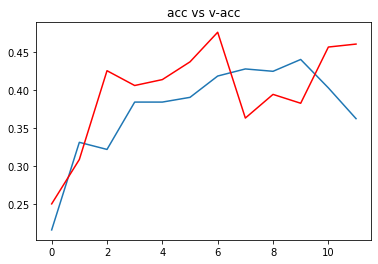

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

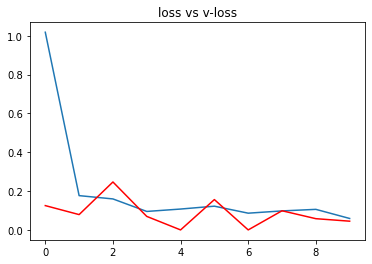

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
# mapear valores
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

 the image is of incorrect


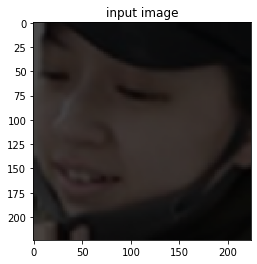

In [ ]:
# Testear el modelo con imagenes introduciendo la ruta

path = "/content/datasetMask/data/original/incorrect/1004.png"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

# to display the image  
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()